In [1]:
set.seed(1234) #set seed

#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)
library(modeldata)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# loading cleaveland dataset
# column names were chosen based on the existing column names in dataset
# except for num, which was changed to diag, short for diagnosis

cleveland_data<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
         col_names=c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","diag")) 
head(cleveland_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  diag = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diag
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [3]:
cleveland_filtered_data <- cleveland_data %>%
                    select(age,trestbps,thalach,chol,oldpeak,diag)%>% #selected the categories decided on (explained below)
                    filter(diag==0|diag==1) %>% #only selected diag values of 0 and 1; values 2-4 were found originally but dataset didn't say what those values meant
                    mutate(diag = as.factor(diag)) %>% #changed diag (target variable) from double -> factor
                    filter(!is.na(age), !is.na(trestbps), !is.na(thalach), !is.na(chol), !is.na(oldpeak), !is.na(diag)) #if any NA's in each column, removes them

head(cleveland_filtered_data)

age,trestbps,thalach,chol,oldpeak,diag
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,150,233,2.3,0
67,120,129,229,2.6,1
37,130,187,250,3.5,0
41,130,172,204,1.4,0
56,120,178,236,0.8,0
57,120,163,354,0.6,0


In [19]:
set.seed(1234)
cleveland_split<-initial_split(cleveland_filtered_data,prop=0.75,strata=diag)  #splitting cleveland's data 
cleveland_training<-training(cleveland_split)
cleveland_testing<-testing(cleveland_split)

In [17]:
set.seed(1234)
training_split <- initial_split(cleveland_training, prop = 0.80, strata = diag) 
training_training <- training(training_split)
training_validation <- testing(training_split)

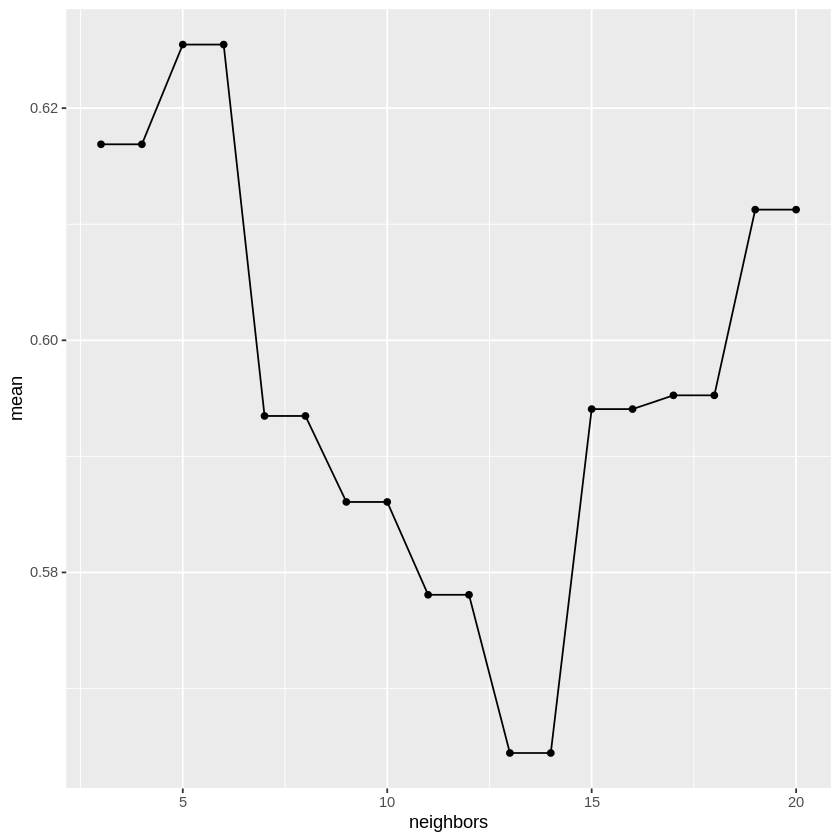

In [21]:
set.seed(1234)
upsample_recipe <- recipe(diag ~ age + trestbps + chol + thalach + oldpeak, data = training_training) %>%
    step_upsample(diag, over_ratio = 1, skip = TRUE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

upsample_vfold <- vfold_cv(training_training, v = 5, strata = diag)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors=tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

grid_vals <- tibble(neighbors = seq(from = 3, to = 20))

knn_fit <- workflow() %>%
     add_recipe(upsample_recipe) %>%
     add_model(knn_tune) %>%
     tune_grid(resamples = upsample_vfold, grid = grid_vals) %>%
     collect_metrics()

accuracies_max <- knn_fit %>% 
     filter(.metric == "accuracy") #%>%
     #arrange(-mean) # %>% 
     #slice(1) #this shows k value with the highest mean
     
k_val <- accuracies_max %>%
   select(neighbors) %>% pull()
 
accuracy_v_k <- ggplot(accuracies_max, aes(x = neighbors, y = mean)) + geom_point() +
    geom_line() 
accuracy_v_k

In [5]:
knn_13 <- nearest_neighbor(weight_func = "rectangular", neighbors=13) %>%
  set_engine("kknn") %>%
  set_mode("classification")

heart_disease_recipe_upscale <- recipe(diag ~ age + trestbps + thalach + chol + oldpeak, data = cleveland_training) %>%
    step_upsample(diag, over_ratio = 1, skip = TRUE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()

knn_fit <- workflow() %>%
     add_recipe(heart_disease_recipe_upscale) %>%
     add_model(knn_13) %>%
     fit(data = cleveland_training)

pred <- predict(knn_fit, cleveland_training) %>%
    bind_cols(cleveland_training)

accuracy <- pred %>%
    metrics(truth = diag, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

accuracy

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7030303
